# Figure 3 - physical projections of ENSO
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from functools import reduce
import matplotlib.patches as mpatches
from scipy import stats

Data locations

In [2]:
loc_enso = "../Data/ENSO_Indices/CMIP6/"
loc_tc = "../Data/Teleconnections/CMIP6/"
loc_e_obs = "../Data/ENSO_Indices/"
loc_shp = "../Data/ProcessedCountryShapefile/"

Year info

In [6]:
y1_obs = 1960
y2_obs = 2019

y1_hist = 1940
y2_hist = 2019
y1_ssp = 2020
y2_ssp = 2100
years_ssp = np.arange(y1_ssp,y2_ssp+1,1)
y1_damages = 2020
y2_damages = 2099
years_damages = np.arange(y1_damages,y2_damages+1,1)

Shapefile

In [4]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

#### Analysis

Observed E-index

In [7]:
obs_e_mon = xr.open_dataset(loc_e_obs+"obs_ENSO_indices_monthly_"+str(y1_obs)+"-"+str(y2_obs)+".nc").e_index
obs_e_shift = obs_e_mon.shift(time=1)

import warnings
warnings.filterwarnings("ignore",category=FutureWarning,message="'base' in .resample")

obs_e = obs_e_shift[obs_e_shift.time.dt.month<=3].resample(time="YS").mean(dim="time")
obs_skewness = stats.skew(obs_e.values)

Set experiments

In [8]:
exp = ["ssp126","ssp245","ssp370","ssp585"] 

In [9]:
count = 0
for k in np.arange(0,len(exp),1):
    e = exp[k]
    print(e)
    
    ## get teleconnections
    models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_tc)) if (exp[k] in m)&("teleconnections_"+str(y1_hist) in m)])
    models_files = np.array([loc_tc+m for m in sorted(os.listdir(loc_tc)) if (exp[k] in m)&("teleconnections_"+str(y1_hist) in m)])
    tc_ds = xr.open_mfdataset(models_files,concat_dim="model",combine="nested")
    tc_ds.coords["model"] = models
    #tc = tc_ds.teleconnections_reg.sel(index="e").load()
    tc = tc_ds.teleconnections_corr_running.sel(index="e").load()
        
    ## also read e-indices to get alpha
    enso_models = np.array([m.split("_")[0]+"_"+m.split("_")[1] for m in sorted(os.listdir(loc_enso)) if exp[k] in m])
    enso_files = np.array([loc_enso+m for m in sorted(os.listdir(loc_enso)) if exp[k] in m])
    enso_ds = xr.open_mfdataset(enso_files,concat_dim="model",combine="nested")
    enso_ds.coords["model"] = enso_models
    alphas = enso_ds.alpha.load()
    alpha_threshold = -0.17 # half the obs value of -0.34
    e_index = enso_ds.e_index.load()
    c_index = enso_ds.c_index.load()
    
    models_intersect = reduce(np.intersect1d,(tc.model.values,alphas.model.values))
    alphas_intersect = alphas.loc[models_intersect]
    models_final = models_intersect[alphas_intersect<alpha_threshold]
    #print(models_intersect)
    #print(models_final)
    
    #print(len(models_final))
    count = count+len(models_final)
    
    modelnames = np.unique(np.array([x.split("_")[0] for x in models_intersect]))
    for nm in modelnames:
        nm_models_all = len([x for x in models_intersect if nm+"_" in x])
        nm_models_final = len([x for x in models_final if nm+"_" in x])
        print(nm+", "+str(nm_models_all)+", "+str(nm_models_final))
        
    e_mon = e_index.shift(time=1)
    c_mon = c_index.shift(time=1)
    #tc_intersect = tc.loc[models_final,:,:]
    def monthly_to_yearly_mean(x):

        # calculate annual mean from monthly data
        # after weighting for the difference in month length
        # x must be data-array with time coord
        # xarray must be installed

        # x_yr = x.resample(time="YS").mean(dim="time") is wrong
        # because it doesn't weight for the # of days in each month

        days_in_mon = x.time.dt.days_in_month
        wgts = days_in_mon.groupby("time.year")/days_in_mon.groupby("time.year").sum()
        ones = xr.where(x.isnull(),0.0,1.0)
        x_sum = (x*wgts).resample(time="YS").sum(dim="time")
        ones_out = (ones*wgts).resample(time="YS").sum(dim="time")
        return(x_sum/ones_out)
    
    # annual E-index
    #e_djf = e_mon[:,e_mon.time.dt.month<=3].resample(time="YS").mean(dim="time")
    #c_djf = c_mon[:,c_mon.time.dt.month<=3].resample(time="YS").mean(dim="time")
    e_djf = monthly_to_yearly_mean(e_mon[:,e_mon.time.dt.month<=3])
    c_djf = monthly_to_yearly_mean(c_mon[:,c_mon.time.dt.month<=3])
    e_djf.coords["time"] = e_djf.time.dt.year.values
    c_djf.coords["time"] = c_djf.time.dt.year.values
    
    # save vars
    if e=="ssp126":
        tc_126 = tc.loc[models_final,:,:]
        e_126 = e_djf.loc[models_final,:]
        e_126_all = e_djf*1.0
        tc_126_all = tc*1.0
    elif e=="ssp245":
        tc_245 = tc.loc[models_final,:,:]
        e_245 = e_djf.loc[models_final,:]
        e_245_all = e_djf*1.0
        tc_245_all = tc*1.0
    elif e=="ssp370":
        tc_370 = tc.loc[models_final,:,:]
        e_370 = e_djf.loc[models_final,:]
        e_370_all = e_djf*1.0
        tc_370_all = tc*1.0
    elif e=="ssp585":
        tc_585 = tc.loc[models_final,:,:]
        e_585 = e_djf.loc[models_final,:]
        e_585_all = e_djf*1.0
        tc_585_all = tc*1.0
        
print(count)

ssp126
CanESM5, 50, 0
KACE-1-0-G, 3, 0
MIROC-ES2L, 7, 7
MIROC6, 50, 50
MRI-ESM2-0, 5, 4
ssp245
ACCESS-CM2, 3, 0
ACCESS-ESM1-5, 11, 0
CAMS-CSM1-0, 1, 0
CESM2, 2, 0
CESM2-WACCM, 3, 2
CMCC-CM2-SR5, 1, 1
CMCC-ESM2, 1, 1
CNRM-CM6-1, 1, 0
CanESM5, 50, 0
EC-Earth3, 8, 8
FGOALS-g3, 3, 0
GFDL-ESM4, 1, 0
HadGEM3-GC31-LL, 1, 0
INM-CM4-8, 1, 0
INM-CM5-0, 1, 0
IPSL-CM6A-LR, 5, 0
KACE-1-0-G, 3, 0
MIROC-ES2L, 30, 30
MIROC6, 33, 33
MPI-ESM1-2-HR, 2, 1
MPI-ESM1-2-LR, 10, 9
NorESM2-LM, 2, 0
NorESM2-MM, 2, 1
UKESM1-0-LL, 5, 0
ssp370
ACCESS-CM2, 3, 0
ACCESS-ESM1-5, 10, 0
CAMS-CSM1-0, 1, 0
CESM2, 2, 0
CESM2-WACCM, 1, 1
CMCC-CM2-SR5, 1, 1
CMCC-ESM2, 1, 1
CNRM-CM6-1, 1, 0
CanESM5, 50, 0
FGOALS-g3, 4, 0
GFDL-ESM4, 1, 0
INM-CM4-8, 1, 0
INM-CM5-0, 5, 0
IPSL-CM6A-LR, 5, 0
KACE-1-0-G, 3, 0
MIROC-ES2L, 10, 10
MIROC6, 3, 3
MPI-ESM1-2-HR, 10, 4
MPI-ESM1-2-LR, 7, 6
MRI-ESM2-0, 5, 5
NorESM2-LM, 1, 1
NorESM2-MM, 1, 1
UKESM1-0-LL, 13, 0
ssp585
ACCESS-CM2, 2, 0
ACCESS-ESM1-5, 6, 0
CAMS-CSM1-0, 1, 0
CESM2, 2, 2
CESM2-WACC

Teleconnection change for each experiment

In [10]:
tc_change_585 = 100*(tc_585.sel(period="future") - tc_585.sel(period="hist"))/tc_585.sel(period="hist")
tc_change_370 = 100*(tc_370.sel(period="future") - tc_370.sel(period="hist"))/tc_370.sel(period="hist")
tc_change_245 = 100*(tc_245.sel(period="future") - tc_245.sel(period="hist"))/tc_245.sel(period="hist")
tc_change_126 = 100*(tc_126.sel(period="future") - tc_126.sel(period="hist"))/tc_126.sel(period="hist")
tc_change_585_all = 100*(tc_585_all.sel(period="future") - tc_585_all.sel(period="hist"))/tc_585_all.sel(period="hist")
tc_change_370_all = 100*(tc_370_all.sel(period="future") - tc_370_all.sel(period="hist"))/tc_370_all.sel(period="hist")
tc_change_245_all = 100*(tc_245_all.sel(period="future") - tc_245_all.sel(period="hist"))/tc_245_all.sel(period="hist")
tc_change_126_all = 100*(tc_126_all.sel(period="future") - tc_126_all.sel(period="hist"))/tc_126_all.sel(period="hist")
tc_585_models = tc_change_585.model.values
tc_370_models = tc_change_370.model.values
tc_245_models = tc_change_245.model.values
tc_126_models = tc_change_126.model.values

In [11]:
print(tc_change_585.mean(dim="iso").median(dim="model").values)
print(tc_change_370.mean(dim="iso").median(dim="model").values)
print(tc_change_245.mean(dim="iso").median(dim="model").values)
print(tc_change_126.mean(dim="iso").median(dim="model").values)

9.811655554657612
14.699779661279068
12.136715471844923
3.782025921265255


Now calculate changes in ENSO amplitude so we can plot histograms

In [12]:
amp_change_585 = 100*(e_585.loc[:,y1_damages:y2_damages].std(dim="time") - e_585.loc[:,y1_hist:y2_hist].std(dim="time"))/e_585.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_370 = 100*(e_370.loc[:,y1_damages:y2_damages].std(dim="time") - e_370.loc[:,y1_hist:y2_hist].std(dim="time"))/e_370.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_245 = 100*(e_245.loc[:,y1_damages:y2_damages].std(dim="time") - e_245.loc[:,y1_hist:y2_hist].std(dim="time"))/e_245.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_126 = 100*(e_126.loc[:,y1_damages:y2_damages].std(dim="time") - e_126.loc[:,y1_hist:y2_hist].std(dim="time"))/e_126.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_585_all = 100*(e_585_all.loc[:,y1_damages:y2_damages].std(dim="time") - e_585_all.loc[:,y1_hist:y2_hist].std(dim="time"))/e_585_all.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_370_all = 100*(e_370_all.loc[:,y1_damages:y2_damages].std(dim="time") - e_370_all.loc[:,y1_hist:y2_hist].std(dim="time"))/e_370_all.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_245_all = 100*(e_245_all.loc[:,y1_damages:y2_damages].std(dim="time") - e_245_all.loc[:,y1_hist:y2_hist].std(dim="time"))/e_245_all.loc[:,y1_hist:y2_hist].std(dim="time")
amp_change_126_all = 100*(e_126_all.loc[:,y1_damages:y2_damages].std(dim="time") - e_126_all.loc[:,y1_hist:y2_hist].std(dim="time"))/e_126_all.loc[:,y1_hist:y2_hist].std(dim="time")

In [13]:
#amp_change_585 = amp_change_585[["MIROC6" in x for x in amp_change_585.model.values]]
#amp_change_370 = amp_change_370[["MIROC6" in x for x in amp_change_370.model.values]]
#amp_change_245 = amp_change_245[["MIROC6" in x for x in amp_change_245.model.values]]
#amp_change_126 = amp_change_126[["MIROC6" in x for x in amp_change_126.model.values]]

Plot

In [14]:
cols = ["darkred","red","salmon","sandybrown"] # 
#cols = np.array([[153,52,4],[204,76,2],[236,112,20],[251,154,41]])/255.
#cols = np.array(["#00441b","#1b7837","#5aae61","#a6dba0"])
names = ["SSP5-8.5","SSP3-7.0","SSP2-4.5","SSP1-2.6"] #,

In [15]:
min_mdl = "MIROC-ES2L_r6i1p1f2"
max_mdl = "CESM2-WACCM_r3i1p1f1"
ex_mdl_amp = amp_change_245
ex_mdl_name = "SSP2-4.5"
min_col = [0.8,0.2,0.2] #np.array([0,119,187])/255.
max_col = "royalblue" # np.array([0,153,136])/255.
amp_change_min = np.around(ex_mdl_amp.loc[min_mdl].values,2)
amp_change_max = np.around(ex_mdl_amp.loc[max_mdl].values,2)

amp
5.343594328091958
69.0
21.108445809316738
79.0
14.840715766422267
79.0
8.703578996378875
70.0
tc
9.811655554657612
76.0
14.699779661279068
85.0
12.136715471844923
86.0
3.782025921265255
64.0
skewness = 1.0216244193394284
skewness = 1.1176702232495241


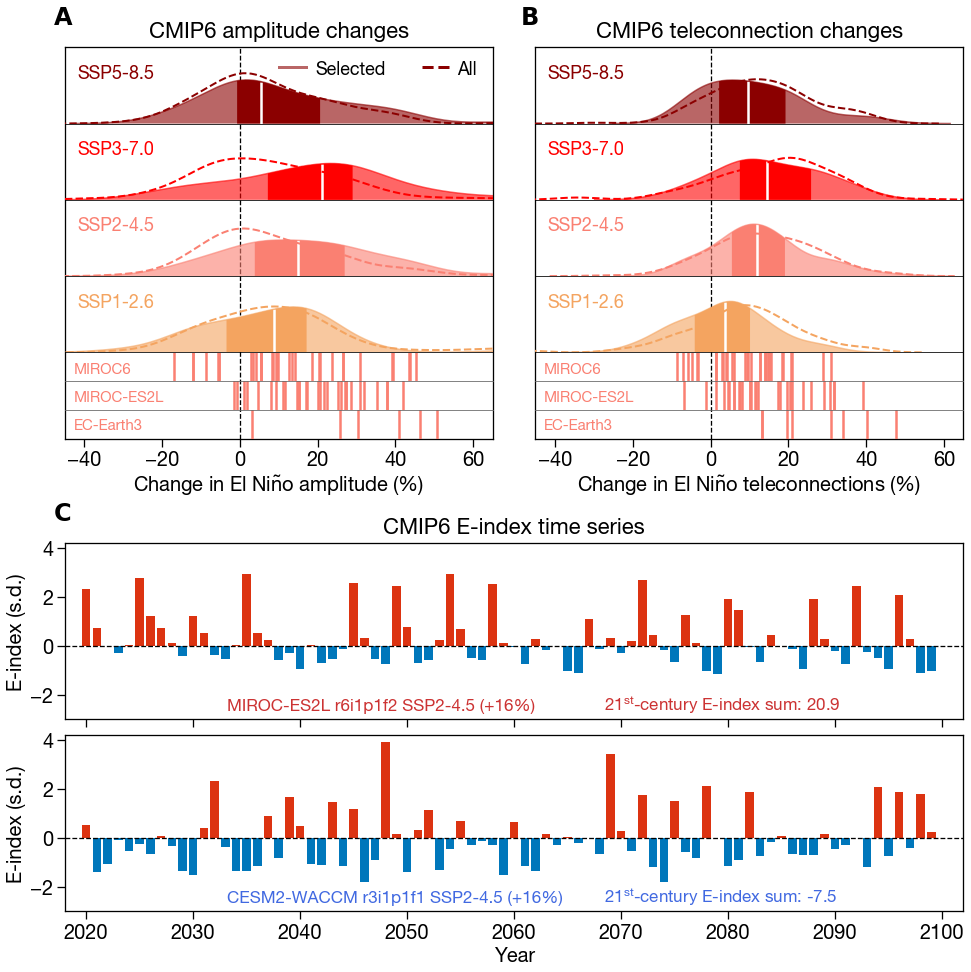

In [16]:
fig = plt.figure(figsize=(16,16))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22

gs1 = gridspec.GridSpec(1,2)
tp = 0.92
gs1.update(left=0.12,right=0.9,top=tp,bottom=0.58,wspace=0.1,hspace=0.35)

for x in [0,1]:
    if x == 0:
        print("amp")
    elif x == 1:
        print("tc")
    ax = plt.subplot(gs1[0,x])
    plt.setp(ax.spines.values(), linewidth=1.3)
    
    if x == 0:
        plt.xlim([-45,65])
        plt.xlabel("Change in El Ni$\~n$o amplitude (%)")
        plt.title("CMIP6 amplitude changes",fontsize=tfs,pad=10)
    elif x == 1:
        plt.xlim([-45,65])
        plt.xlabel("Change in El Ni$\~n$o teleconnections (%)")
        plt.title("CMIP6 teleconnection changes",fontsize=tfs,pad=10)
    plt.yticks([])

    for k in [0,1,2,3]:
        if (x==0) & (k == 0):
            data = amp_change_585
            data1 = amp_change_585_all
        elif (x==0)&(k==1):
            data = amp_change_370
            data1 = amp_change_370_all
        elif (x==0)&(k==2):
            data = amp_change_245
            data1 = amp_change_245_all
        elif (x==0)&(k==3):
            data = amp_change_126
            data1 = amp_change_126_all
        elif (x==1) & (k == 0):
            data = tc_change_585.mean(dim="iso")
            data1 = tc_change_585_all.mean(dim="iso")
        elif (x==1)&(k==1):
            data = tc_change_370.mean(dim="iso")
            data1 = tc_change_370_all.mean(dim="iso")
        elif (x==1)&(k==2):
            data = tc_change_245.mean(dim="iso")
            data1 = tc_change_245_all.mean(dim="iso")
        elif (x==1)&(k==3):
            data = tc_change_126.mean(dim="iso")
            data1 = tc_change_126_all.mean(dim="iso")

        print(np.nanmedian(data))
        print(np.around(100*len(data[data>0])/len(data)))
        inset_col = [0.4,0.4,0.4]
        #b = 0.283+(0.155*k)
        w = 0.372
        h = 0.0662
        b = (tp - h) - (h*k)
        if x == 0: 
            l = 0.12
        elif x == 1:
            l = 0.528
        inset_ax = fig.add_axes([l,b,w,h])
        inset_ax.spines["left"].set_visible(False)
        inset_ax.spines["top"].set_visible(False)
        #inset_ax.spines["right"].set_visible(False)
        #if k != 0:
        #    inset_ax.spines["bottom"].set_visible(False)
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        inset_ax.patch.set_alpha(0)

        if (x==0)&(k==0):
            sns.kdeplot(list(data),alpha=0.6,color=cols[k],shade=True,
                       label="Selected")
        else:
            sns.kdeplot(list(data),alpha=0.6,color=cols[k],shade=True)
        if x==0:
            inset_ax.set_xlim([-45,65])
            inset_ax.set_ylim([0,0.04])
        if x==1:
            inset_ax.set_xlim([-45,65])
            inset_ax.set_ylim([0,0.05])
        med = np.median(data.values)
        kdeline = inset_ax.lines[0]
        xs = kdeline.get_xdata()
        ys = kdeline.get_ydata()
        height = np.interp(med, xs, ys)
        inset_ax.vlines(med,0,height,color='white',linewidth=2.5)
        left,middle,right = np.percentile(data,[25,50,75])
        inset_ax.fill_between(xs,0,ys,where=(left<=xs)&(xs<=right),
                              facecolor=cols[k],alpha=1)

        inset_ax.text(0.03,0.6,names[k],fontsize=18,color=cols[k],
                     transform=inset_ax.transAxes)
        if (x==0)&(k==0):
            sns.kdeplot(list(data1),alpha=1,color=cols[k],shade=False,
                    linestyle="--",linewidth=2,label="All")
            leg = inset_ax.legend(loc="upper right",frameon=False,fontsize=18,
                           handlelength=1.5,handletextpad=0.5,ncol=2,
                                 bbox_to_anchor=(1,1.05,0,0))
            for legobj in leg.legendHandles:
                legobj.set_linewidth(3.0)
        else:
            sns.kdeplot(list(data1),alpha=1,color=cols[k],shade=False,
                    linestyle="--",linewidth=2)
            
    ax.axvline(x=0,linewidth=1.3,color="black",linestyle="--",zorder=5)



    ## insets
    mdl_examples = ["EC-Earth3","MIROC-ES2L","MIROC6"]
    if x == 0:
        data_ex = amp_change_245*1.0
    elif x == 1:
        data_ex = tc_change_245.mean(dim="iso")
    ex_ind = 2
    for j in np.arange(0,len(mdl_examples),1):
        inset_col = [0.4,0.4,0.4]
        h = 0.025
        b = 0.58+(h*j)
        w = 0.372
        if x == 0:
            l = 0.12
        elif x == 1:
            l = 0.528
        inset_ax = fig.add_axes([l,b,w,h])
        if x == 0:
            inset_ax.set_xlim([-45,65])
        elif x == 1:
            inset_ax.set_xlim([-45,65])
        inset_ax.set_ylim([0,1])
        inset_fs = 16
        inset_ax.spines["right"].set_visible(False)
        if j == 0:
            inset_ax.spines["top"].set_color(inset_col)
            plt.text(0.02,0.34,mdl_examples[j],color=cols[ex_ind],fontsize=15,transform=inset_ax.transAxes)
        elif j == 1:
            inset_ax.spines["top"].set_color(inset_col)
            plt.text(0.02,0.3,mdl_examples[j],color=cols[ex_ind],fontsize=15,transform=inset_ax.transAxes)
        else:
            inset_ax.spines["top"].set_visible(False)
            plt.text(0.02,0.3,mdl_examples[j],color=cols[ex_ind],fontsize=15,transform=inset_ax.transAxes)
        #inset_ax.spines["top"].set_visible(False)
        inset_ax.spines["bottom"].set_visible(False)
        inset_ax.spines["left"].set_visible(False)
        inset_ax.patch.set_alpha(0)
        inset_ax.set_yticks([])
        inset_ax.set_xticks([])


        mdl_data = data_ex.loc[[mdl_examples[j] in x for x in data_ex.model.values]].values
        for k in mdl_data:
            plt.plot([k,k],[0,1],linewidth=2.5,color=cols[2],linestyle='-')





gs2 = gridspec.GridSpec(2,1)
gs2.update(left=0.12,right=0.9,top=0.49,bottom=0.17,wspace=0.3,hspace=0.09)

e_future = e_245.loc[:,y1_damages:y2_damages]
for k in [0,1]:
    if k == 0:
        mdl = min_mdl
        amp_change_mdl = amp_change_min
        cc = min_col
    else:
        mdl = max_mdl
        amp_change_mdl = amp_change_max
        cc = max_col
    #mdl_txt = mdl.split("_")[0]+"\n"+mdl.split("_")[1]+" (+"+str(amp_change_mdl)+"%)"
    mdl_txt = mdl.split("_")[0]+" "+mdl.split("_")[1]+" "+ex_mdl_name+" (+"+str(int(amp_change_mdl))+"%)"
    
    ax = plt.subplot(gs2[k,0])
    plt.setp(ax.spines.values(), linewidth=1.3)

    time = e_future.time.values
    mdl_e = e_future.loc[mdl,:]
    # color=cc
    plt.bar(x=time[mdl_e<0],height=mdl_e[mdl_e<0],color=np.array([0,119,187])/255.)
    plt.bar(x=time[mdl_e>0],height=mdl_e[mdl_e>0],color=np.array([220,51,17])/255.)

    ls = "-"
    a = 0.6

    plt.ylabel("E-index (s.d.)")
    
    plt.axhline(y=0,color="black",linestyle="--",linewidth=1.3,zorder=1)
    if k == 0:
        plt.xticks(ticks=np.arange(2020,2100+10,10),
                  labels=[])
        plt.title("CMIP6 E-index time series",fontsize=tfs,pad=10)
    else:
        plt.xticks(ticks=np.arange(2020,2100+10,10))
        plt.xlabel("Year")
        
    plt.xlim([2018,2102])
    plt.yticks([-2,0,2,4])
    plt.ylim([-3,4.2])
    plt.text(0.18,0.05,mdl_txt,fontsize=17,ha="left",
            transform=ax.transAxes,color=cc)
    e_mdl = e_future.loc[mdl,2020:2099]
    print("skewness = "+str(stats.skew(e_mdl.values)))
    e_str = np.around(e_mdl.sum(dim="time").values,1)
    plt.text(0.6,0.05,"21$^{st}$-century E-index sum: "+str(e_str),color=cc,
            fontsize=17,ha="left",transform=ax.transAxes)
    
plt.figtext(0.11,0.94,r'$\bf{A}$',fontsize=24)
plt.figtext(0.515,0.94,r'$\bf{B}$',fontsize=24)
plt.figtext(0.11,0.51,r'$\bf{C}$',fontsize=24)


plt.savefig("../Figures/Fig3.pdf")
plt.show()

In [17]:
np.sort(amp_change_245[["MIROC6" in x for x in amp_change_245.model.values]])

array([-17.01216965, -12.13122355, -12.08993677,  -8.84046641,
        -5.64519528,  -5.553672  ,  -5.36422359,   2.87341756,
         3.18940966,   4.12153161,   5.22830162,   5.23087731,
         5.46614743,   8.28463015,   8.45212893,   9.10180596,
         9.48860962,   9.76541355,  12.52537938,  13.30896232,
        14.10108582,  18.32944571,  20.18097703,  20.51560436,
        23.62829517,  26.31725528,  26.48414405,  30.67683106,
        39.07289394,  39.29546169,  43.46396577,  43.53989904,
        45.08998172])

In [18]:
np.sort(amp_change_245[["MIROC-ES2L" in x for x in amp_change_245.model.values]])

array([-1.58083855, -0.74056471,  1.06049812,  1.82212489,  4.64600234,
        7.80066984,  9.13126959, 10.96263046, 11.4541437 , 14.57386743,
       15.1075641 , 15.17478777, 16.86930852, 17.21993593, 20.02627365,
       20.41096819, 21.4849687 , 22.35471689, 25.07015944, 25.91616648,
       26.98541031, 27.05069076, 27.10117071, 28.43809682, 30.6533503 ,
       31.85324416, 35.17115057, 37.82058949, 37.82454771, 41.82395368])

In [19]:
np.sort(amp_change_245[["EC-Earth3" in x for x in amp_change_245.model.values]])

array([ 3.05189398, 25.75389304, 30.37866023, 40.7425336 , 46.16123824,
       50.43770485, 65.55641905, 70.52929492])

Histogram of scenario and E-index values

In [20]:
y1_sum = 2020
y2_sum = 2099
e_sum_126 = e_126.loc[:,y1_sum:y2_sum].sum(dim="time")
e_sum_245 = e_245.loc[:,y1_sum:y2_sum].sum(dim="time")
e_sum_370 = e_370.loc[:,y1_sum:y2_sum].sum(dim="time")
e_sum_585 = e_585.loc[:,y1_sum:y2_sum].sum(dim="time")

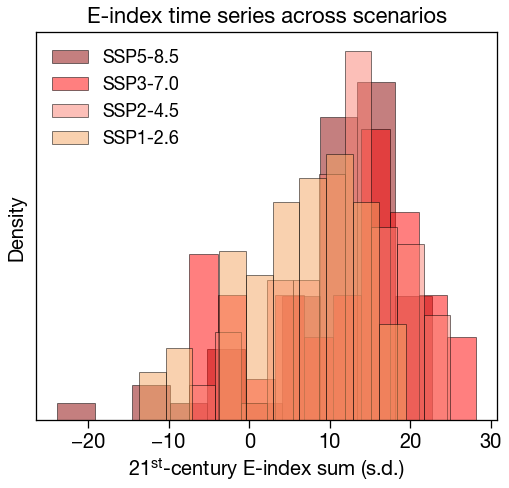

In [21]:
fig = plt.figure(figsize=(8,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3
rcParams["mathtext.default"] = "regular"

tfs = 22

gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.12,right=0.92,top=0.9,bottom=0.13,wspace=0.3,hspace=0.35)

ax = plt.subplot(gs1[0,0])
plt.setp(ax.spines.values(), linewidth=1.3)

cols = ["darkred","red","salmon","sandybrown"] # 
#cols = np.array([[153,52,4],[204,76,2],[236,112,20],[251,154,41]])/255.
#cols = np.array(["#00441b","#1b7837","#5aae61","#a6dba0"])
names = ["SSP5-8.5","SSP3-7.0","SSP2-4.5","SSP1-2.6"] #,

alph = 0.5
plt.hist(e_sum_585.values,facecolor=cols[0],label=names[0],
        alpha=alph,edgecolor="black",density=True)
plt.hist(e_sum_370.values,facecolor=cols[1],label=names[1],
        alpha=alph,edgecolor="black",density=True)
plt.hist(e_sum_245.values,facecolor=cols[2],label=names[2],
        alpha=alph,edgecolor="black",density=True)
plt.hist(e_sum_126.values,facecolor=cols[3],label=names[3],
        alpha=alph,edgecolor="black",density=True)

plt.legend(loc="upper left",frameon=False,fontsize=18)

plt.ylabel("Density",labelpad=10)
plt.xlabel("21$^{st}$-century E-index sum (s.d.)")
plt.yticks([])

plt.title("E-index time series across scenarios",fontsize=22,pad=10)

plt.savefig("../Figures/FigX_Eindex_Sum.pdf")
plt.show()